# Two-stage Model Visualization

`two_stage_xgb.py`에서 사용하는 데이터와 전처리/피처 생성 로직을 활용하여
간단한 탐색적 데이터 분석(EDA)과 시각화를 수행하는 노트북입니다.

- 데이터 로딩 및 피처 생성
- 매출수량 분포 및 로그 분포
- 예시 영업장/메뉴 시계열 패턴
- 요일/월별 평균 매출 패턴

In [1]:
# 라이브러리 및 프로젝트 모듈 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform

In [2]:
# 주피터 노트북 매직 커맨드
%matplotlib inline

# 그래프 스타일 설정
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

# 한글 폰트 설정 (OS에 맞게 자동 설정)
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

In [3]:
# two_stage_xgb 모듈 임포트 (같은 폴더에 있다고 가정)
import two_stage_xgb as tsx

# 데이터 디렉토리 설정
BASE_DIR = os.getenv("DATA_DIR", os.path.dirname(os.path.abspath(tsx.__file__)))
BASE_DIR

'c:\\Users\\DS29\\Documents\\proj\\ml\\open'

In [4]:
# 데이터 로딩 및 피처 생성
train, test_files, sample_submission = tsx.load_data(BASE_DIR)

train_fe = tsx.build_features(train)

print("train shape:", train.shape)
print("train_fe shape:", train_fe.shape)
train_fe.head()

train shape: (102676, 3)
train_fe shape: (102676, 25)


,영업일자,영업장명_메뉴명,매출수량,요일,주차,월,계절,is_weekend,month_period,is_before_weekend,...,menu_len,menu_token_cnt,is_premium,rolling_7_mean,rolling_30_mean,rolling_ratio,lag_1,lag_7,lag_7_ratio,메뉴_인코딩
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,6,52,1,0,1,1,0,...,7,2,1,0.0,0.0,0.0,0.0,0.0,0.0,5.088346
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,0,1,1,0,0,1,0,...,7,2,1,0.0,0.0,0.0,0.0,0.0,0.0,5.088346
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,1,1,1,0,0,1,0,...,7,2,1,0.0,0.0,0.0,0.0,0.0,0.0,5.088346
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,2,1,1,0,0,1,0,...,7,2,1,0.0,0.0,0.0,0.0,0.0,0.0,5.088346
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,3,1,1,0,0,1,0,...,7,2,1,0.0,0.0,0.0,0.0,0.0,0.0,5.088346


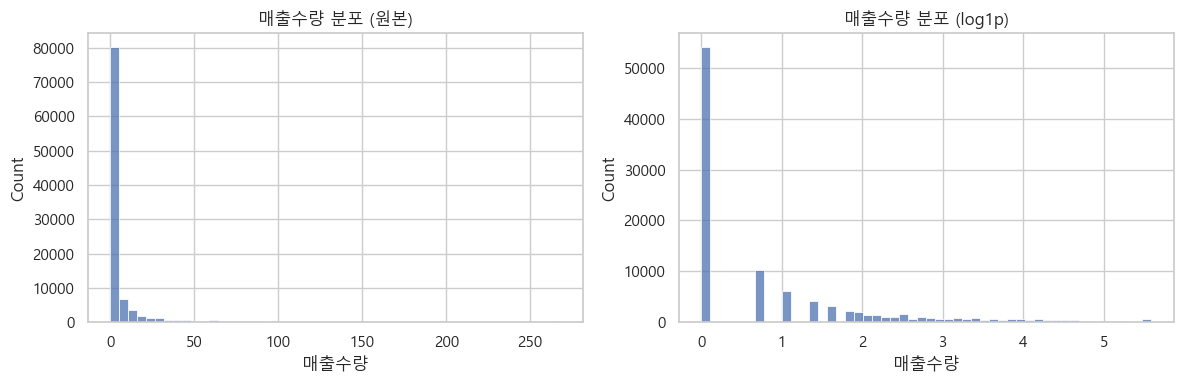

In [5]:
# 매출수량 분포 (원본 스케일)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train_fe["매출수량"], bins=50, ax=axes[0])
axes[0].set_title("매출수량 분포 (원본)")

sns.histplot(np.log1p(train_fe["매출수량"]), bins=50, ax=axes[1])
axes[1].set_title("매출수량 분포 (log1p)")

plt.tight_layout()
plt.show()

In [6]:
# 예시 영업장_메뉴 하나 선택하여 시계열 플롯
example_key = train_fe["영업장명_메뉴명"].iloc[0]
print("예시 영업장_메뉴:", example_key)

ex_df = (
    train_fe[train_fe["영업장명_메뉴명"] == example_key]
    .sort_values("영업일자")
)

예시 영업장_메뉴: 느티나무 셀프BBQ_1인 수저세트


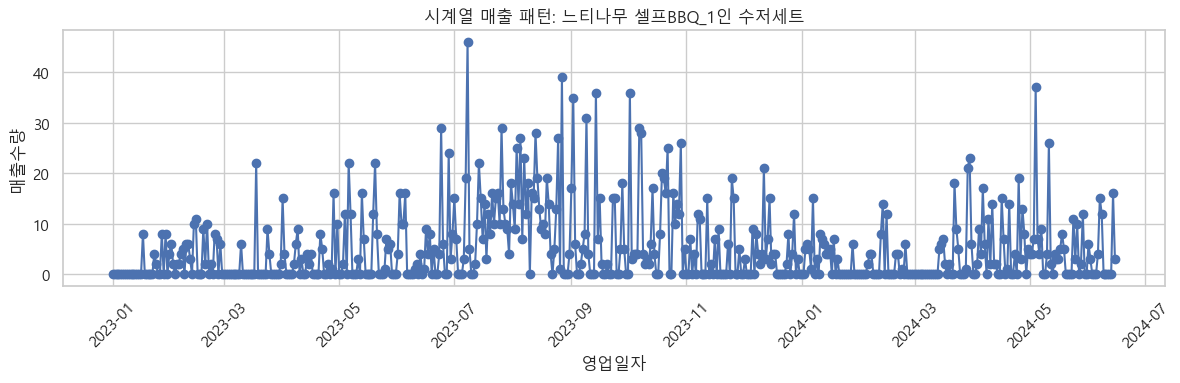

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ex_df["영업일자"], ex_df["매출수량"], marker="o")
ax.set_title(f"시계열 매출 패턴: {example_key}")
ax.set_xlabel("영업일자")
ax.set_ylabel("매출수량")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

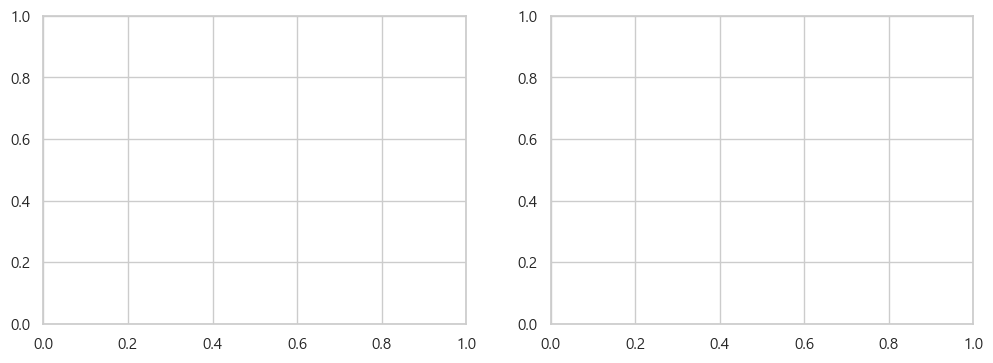

In [8]:
# 요일/월별 평균 매출 패턴

weekday_mean = train_fe.groupby("요일")["매출수량"].mean()
month_mean = train_fe.groupby("월")["매출수량"].mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

In [9]:
axes[0].bar(weekday_mean.index, weekday_mean.values)
axes[0].set_title("요일별 평균 매출")
axes[0].set_xlabel("요일 (0=월, 6=일)")

axes[1].bar(month_mean.index, month_mean.values)
axes[1].set_title("월별 평균 매출")
axes[1].set_xlabel("월")

plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

In [10]:
train_fe_corr = train_fe.corr(numeric_only=True)
train_fe_corr.to_csv("train_fe_corr.csv")
display(train_fe_corr)

,매출수량,요일,주차,월,계절,is_weekend,month_period,is_before_weekend,is_after_weekend,is_group,...,menu_len,menu_token_cnt,is_premium,rolling_7_mean,rolling_30_mean,rolling_ratio,lag_1,lag_7,lag_7_ratio,메뉴_인코딩
매출수량,1.000000,6.070634e-02,-3.561704e-02,-3.794219e-02,-6.848637e-02,5.165335e-02,4.438164e-03,1.913183e-02,-3.419465e-02,8.114578e-02,...,-5.766848e-02,-7.174750e-02,3.173019e-02,0.805800,0.736380,0.155182,0.767396,0.751788,0.138823,4.667558e-01
요일,0.060706,1.000000e+00,5.405932e-03,1.569960e-02,3.586032e-03,7.905694e-01,-5.736677e-03,2.041241e-01,-6.123724e-01,-1.743009e-15,...,-1.139358e-15,-2.814320e-15,-2.446527e-15,-0.002460,-0.002278,-0.002407,0.032771,0.060225,-0.021998,5.051915e-15
주차,-0.035617,5.405932e-03,1.000000e+00,9.852902e-01,6.498233e-01,5.698353e-03,7.642618e-02,-1.471308e-03,-1.471308e-03,-3.292293e-15,...,5.486277e-16,-5.086945e-16,-3.857187e-15,-0.057529,-0.080712,0.110590,-0.041175,-0.049882,0.002638,1.097546e-15
월,-0.037942,1.569960e-02,9.852902e-01,1.000000e+00,6.641233e-01,1.134777e-02,3.776235e-03,5.722620e-03,-1.030072e-02,-6.284460e-15,...,-9.993890e-16,-4.398612e-15,-8.207780e-15,-0.055772,-0.078825,0.119097,-0.039415,-0.047665,0.005383,9.281144e-15
계절,-0.068486,3.586032e-03,6.498233e-01,6.641233e-01,1.000000e+00,1.134003e-03,-1.141741e-02,7.319958e-04,-4.391975e-03,4.779082e-16,...,-1.764330e-15,-1.414125e-15,4.699661e-16,-0.076738,-0.082670,0.052247,-0.066906,-0.058049,0.001101,3.618906e-15
is_weekend,0.051653,7.905694e-01,5.698353e-03,1.134777e-02,1.134003e-03,1.000000e+00,-5.805109e-03,-2.581989e-01,-2.581989e-01,4.584066e-16,...,-2.583331e-17,8.058610e-16,7.394402e-16,-0.001936,0.000261,-0.007382,0.048419,0.051331,0.012423,-2.096549e-15
month_period,0.004438,-5.736677e-03,7.642618e-02,3.776235e-03,-1.141741e-02,-5.805109e-03,1.000000e+00,-1.030475e-02,-1.030475e-02,-1.127783e-15,...,2.182426e-16,-1.199937e-15,-1.895114e-15,-0.005773,-0.005414,-0.017165,-0.000104,-0.002711,-0.023985,2.316659e-15
is_before_weekend,0.019132,2.041241e-01,-1.471308e-03,5.722620e-03,7.319958e-04,-2.581989e-01,-1.030475e-02,1.000000e+00,-1.666667e-01,-5.135736e-16,...,-2.408815e-16,-6.242371e-16,-6.518958e-16,-0.000265,-0.001547,0.002642,-0.003038,0.018741,-0.014584,1.291261e-15
is_after_weekend,-0.034195,-6.123724e-01,-1.471308e-03,-1.030072e-02,-4.391975e-03,-2.581989e-01,-1.030475e-02,-1.666667e-01,1.000000e+00,-1.144528e-15,...,-3.290760e-16,-1.073429e-15,-1.521062e-15,0.001582,0.004408,-0.009688,0.022316,-0.033874,0.064821,1.821499e-15
is_group,0.081146,-1.743009e-15,-3.292293e-15,-6.284460e-15,4.779082e-16,4.584066e-16,-1.127783e-15,-5.135736e-16,-1.144528e-15,1.000000e+00,...,2.232708e-01,1.474955e-01,6.966587e-01,0.090422,0.085962,0.027367,0.080861,0.077732,0.133283,1.738506e-01


In [11]:
# 학습/테스트용 피처 생성 및 카테고리 인코딩

# train 피처는 앞에서 생성한 train_fe 사용
# test 파일들도 동일한 피처 생성 적용

test_list = []
for name, df in test_files.items():
    df_copy = df.copy()
    df_copy["test_file"] = name
    test_list.append(df_copy)

In [12]:
for i, item in enumerate(test_list):
    test_list[i] = tsx.build_features(item)

# 카테고리 인코딩은 train 기준으로만 학습 후, test에 동일 매핑 적용
cat_cols = [c for c in [
    "영업장명_메뉴명", "영업장명", "메뉴명"
] if c in train_fe.columns]


In [13]:
train_enc, test_enc_list, encoders = tsx.encode_train_only(
    train_fe,
    test_list,
    cat_cols,
)

In [14]:
# 메뉴별 평균 매출(타깃 인코딩용)과 전체 평균
menu_mean_train = train.groupby("영업장명_메뉴명")["매출수량"].mean().to_dict()
global_mean_train = float(train["매출수량"].mean())

In [15]:
# two_stage_xgb.py 에서 사용한 feature_cols 그대로 재현
feature_cols = [
    "요일",
    "월",
    "계절",
    "is_weekend",
    "영업장명_메뉴명",
    "메뉴명",
    "is_group",
    "is_dessert",
    "rolling_7_mean",
    "rolling_30_mean",
    "메뉴_인코딩",
    "month_period",
    "is_before_weekend",
    "is_after_weekend",
    "menu_len",
    "menu_token_cnt",
    "is_premium",
    "rolling_ratio",
    "lag_1",
    "lag_7",
    "lag_7_ratio",
]
feature_cols = [c for c in feature_cols if c in train_enc.columns]

len(feature_cols), feature_cols

(21,
 ['요일',
  '월',
  '계절',
  'is_weekend',
  '영업장명_메뉴명',
  '메뉴명',
  'is_group',
  'is_dessert',
  'rolling_7_mean',
  'rolling_30_mean',
  '메뉴_인코딩',
  'month_period',
  'is_before_weekend',
  'is_after_weekend',
  'menu_len',
  'menu_token_cnt',
  'is_premium',
  'rolling_ratio',
  'lag_1',
  'lag_7',
  'lag_7_ratio'])

In [16]:
# 검증용 2-stage XGBoost 모델 학습 및 zero_threshold 탐색
from importlib import reload
reload(tsx)  # two_stage_xgb.py 수정 후 노트북에서 바로 반영하고 싶을 때 사용

_clf_tmp, _reg_tmp, _train_split, _valid_split, best_zero_threshold = tsx.train_two_stage(
    train_enc,
    feature_cols,
    valid_ratio=0.1,
)

best_zero_threshold

[VALID] Threshold sweep (coarse):
  thr=0.10 -> SMAPE=146.7651
  thr=0.20 -> SMAPE=128.7544
  thr=0.30 -> SMAPE=116.7260
  thr=0.40 -> SMAPE=106.3929
  thr=0.50 -> SMAPE=102.2133
  thr=0.60 -> SMAPE=101.6940
  thr=0.70 -> SMAPE=104.2737
  thr=0.80 -> SMAPE=110.1809
  thr=0.90 -> SMAPE=115.4278
[VALID] Threshold sweep (fine):
  thr=0.55 -> SMAPE=101.5093
  thr=0.56 -> SMAPE=101.5519
  thr=0.57 -> SMAPE=101.4209
  thr=0.58 -> SMAPE=101.5261
  thr=0.59 -> SMAPE=101.6611
  thr=0.60 -> SMAPE=101.6940
  thr=0.61 -> SMAPE=101.7422
  thr=0.62 -> SMAPE=101.7501
  thr=0.63 -> SMAPE=102.1543
  thr=0.64 -> SMAPE=102.5357
  thr=0.65 -> SMAPE=102.4761
[VALID] Best zero_threshold: 0.5700
[VALID] SMAPE_all: 101.4209
[VALID] SMAPE_competition: 75.5183
[VALID] RMSE: 15.6359
[VALID] MAE: 5.0494
[VALID] SMAPE_all (int): 100.9577
[VALID] SMAPE_competition (int): 74.9334
[VALID] RMSE (int): 15.6400
[VALID] MAE (int): 5.0482


0.57

In [17]:
# 전체 train_enc 를 이용한 2-stage 앙상블 학습 (XGBoost / LightGBM / CatBoost)

ensemble_seeds = [42, 2025, 777]
ensemble_models = []  # (clf, reg) 튜플들의 리스트

In [18]:
# XGBoost 기반 2-stage 모델들
for seed in ensemble_seeds:
    tsx.log(f"[INFO] Training XGBoost full model with seed={seed}")
    clf_i, reg_i = tsx.fit_two_stage_full(train_enc, feature_cols, random_state=seed)
    ensemble_models.append((clf_i, reg_i))

[INFO] Training XGBoost full model with seed=42
[INFO] Training XGBoost full model with seed=2025
[INFO] Training XGBoost full model with seed=777


In [19]:
# LightGBM 기반 2-stage 모델들
for seed in ensemble_seeds:
    tsx.log(f"[INFO] Training LightGBM full model with seed={seed}")
    clf_i, reg_i = tsx.fit_two_stage_full_lgbm(train_enc, feature_cols, random_state=seed)
    ensemble_models.append((clf_i, reg_i))

[INFO] Training LightGBM full model with seed=42
[LightGBM] [Info] Number of positive: 54048, number of negative: 48628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2133
[LightGBM] [Info] Number of data points in the train set: 102676, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526394 -> initscore=0.105673
[LightGBM] [Info] Start training from score 0.105673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2124
[LightGBM] [Info] Number of data points in the train set: 48628, number of used features: 21
[LightGBM] [Info] Start training from sco

In [20]:

# CatBoost 기반 2-stage 모델들
for seed in ensemble_seeds:
    tsx.log(f"[INFO] Training CatBoost full model with seed={seed}")
    clf_i, reg_i = tsx.fit_two_stage_full_catboost(train_enc, feature_cols, random_state=seed)
    ensemble_models.append((clf_i, reg_i))

len(ensemble_models)

[INFO] Training CatBoost full model with seed=42
[INFO] Training CatBoost full model with seed=2025
[INFO] Training CatBoost full model with seed=777


9

In [21]:
# TEST 세트에서 단일/평균/median 앙상블 성능 확인

for idx, df_enc in enumerate(test_enc_list):
    X_test = df_enc[feature_cols]
    y_true = df_enc["매출수량"].values

    preds_list = []
    for model_idx, (clf_i, reg_i) in enumerate(ensemble_models):
        pred_i = tsx.predict_two_stage(clf_i, reg_i, X_test, zero_threshold=best_zero_threshold)
        preds_list.append(pred_i)
        if model_idx == 0:
            tsx.log(
                f"[TEST {idx}] [MODEL {model_idx}] SMAPE_competition:",
                f"{tsx.smape_competition_like(y_true, pred_i):.4f}",
            )

    preds_stack = np.vstack(preds_list)

    # 평균 앙상블
    pred_mean = preds_stack.mean(axis=0)
    tsx.log(f"[TEST {idx}] [MEAN] SMAPE_all:", f"{tsx.smape(y_true, pred_mean):.4f}")
    tsx.log(
        f"[TEST {idx}] [MEAN] SMAPE_competition:",
        f"{tsx.smape_competition_like(y_true, pred_mean):.4f}",
    )

    # median 앙상블
    pred_median = np.median(preds_stack, axis=0)
    tsx.log(f"[TEST {idx}] [MED] SMAPE_all:", f"{tsx.smape(y_true, pred_median):.4f}")
    tsx.log(
        f"[TEST {idx}] [MED] SMAPE_competition:",
        f"{tsx.smape_competition_like(y_true, pred_median):.4f}",
    )

[TEST 0] [MODEL 0] SMAPE_competition: 85.1761
[TEST 0] [MEAN] SMAPE_all: 108.4621
[TEST 0] [MEAN] SMAPE_competition: 82.6503
[TEST 0] [MED] SMAPE_all: 107.7480
[TEST 0] [MED] SMAPE_competition: 85.2787
[TEST 1] [MODEL 0] SMAPE_competition: 77.4945
[TEST 1] [MEAN] SMAPE_all: 97.7274
[TEST 1] [MEAN] SMAPE_competition: 74.6586
[TEST 1] [MED] SMAPE_all: 97.3478
[TEST 1] [MED] SMAPE_competition: 77.5158
[TEST 2] [MODEL 0] SMAPE_competition: 90.5788
[TEST 2] [MEAN] SMAPE_all: 113.0336
[TEST 2] [MEAN] SMAPE_competition: 88.6185
[TEST 2] [MED] SMAPE_all: 111.8165
[TEST 2] [MED] SMAPE_competition: 91.1303
[TEST 3] [MODEL 0] SMAPE_competition: 74.8331
[TEST 3] [MEAN] SMAPE_all: 96.2668
[TEST 3] [MEAN] SMAPE_competition: 72.3981
[TEST 3] [MED] SMAPE_all: 94.5490
[TEST 3] [MED] SMAPE_competition: 74.4663
[TEST 4] [MODEL 0] SMAPE_competition: 76.4775
[TEST 4] [MEAN] SMAPE_all: 98.7999
[TEST 4] [MEAN] SMAPE_competition: 72.6626
[TEST 4] [MED] SMAPE_all: 98.4688
[TEST 4] [MED] SMAPE_competition: 75.5

In [22]:
# submission.csv 생성: TEST_00~09 각각의 마지막 날짜 이후 7일 예측

sub = sample_submission.copy()
menu_cols = [c for c in sub.columns if c != "영업일자"]

forecasts_by_test = {}
forecast_date_rows = []  # TEST별 실제 예측 날짜 정보 저장

for test_id in range(10):
    test_name = f"TEST_{test_id:02d}.csv"
    if test_name not in test_files:
        continue

    test_df_raw = test_files[test_name]
    last_date = pd.to_datetime(test_df_raw["영업일자"].max())

    preds_7_list = []
    for clf_i, reg_i in ensemble_models:
        preds_7_i = tsx.forecast_7days_for_test(
            test_df_raw=test_df_raw,
            menu_cols=menu_cols,
            clf=clf_i,
            reg=reg_i,
            feature_cols=feature_cols,
            menu_mean_train=menu_mean_train,
            global_mean_train=global_mean_train,
            cat_encoders=encoders,
            zero_threshold=best_zero_threshold,
            horizon=7,
        )
        preds_7_list.append(preds_7_i)

    # DataFrame 평균 앙상블
    preds_7_mean = sum(preds_7_list) / len(preds_7_list)
    forecasts_by_test[f"TEST_{test_id:02d}"] = preds_7_mean

    for d in range(1, 8):
        cur_date = last_date + pd.Timedelta(days=d)
        forecast_date_rows.append(
            {
                "test_id": f"TEST_{test_id:02d}",
                "day_offset": d,
                "forecast_date": cur_date.strftime("%Y-%m-%d"),
            }
        )

In [23]:
for i in range(len(sub)):
    key = str(sub.loc[i, "영업일자"])
    if "+" not in key:
        continue
    test_key, offset_str = key.split("+", 1)
    day = int(offset_str.replace("일", ""))
    if test_key not in forecasts_by_test:
        continue
    row_pred = forecasts_by_test[test_key].loc[day]
    sub.loc[i, menu_cols] = row_pred.values

In [24]:
# 제출 포맷: 정수화 + 음수 방지
sub[menu_cols] = sub[menu_cols].astype(float).round().clip(lower=0).astype(int)

output_path = os.path.join(BASE_DIR, "submission.csv")
sub.to_csv(output_path, index=False, encoding="utf-8-sig")
print("[INFO] submission saved:", output_path)

[INFO] submission saved: c:\Users\DS29\Documents\proj\ml\open\submission.csv


In [25]:
# TEST별 예측 날짜 정보도 별도 CSV로 저장
if forecast_date_rows:
    forecast_dates_df = pd.DataFrame(forecast_date_rows)
    forecast_dates_path = os.path.join(BASE_DIR, "forecast_dates_by_test.csv")
    forecast_dates_df.to_csv(forecast_dates_path, index=False, encoding="utf-8-sig")
    print("[INFO] forecast dates saved:", forecast_dates_path)

[INFO] forecast dates saved: c:\Users\DS29\Documents\proj\ml\open\forecast_dates_by_test.csv
